In [1]:
from info_task_exp import *
from info_model import *
from funcs_model_analysis import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Embedding activity

### load model

In [3]:
model = load_winning_model(datasetType='data', modelName='LSTM_embed')

{'hidden_size': 50, 'n_epochs': 200, 'lr_init': 0.001, 'lr_adjust_type': 'Adam', 'batch_size': 10000, 'embed_size': {'subjID': 3}} 23
GPU not available, CPU used
GPU not available, CPU used


### embedding activity

In [4]:
for name, param in model.named_parameters():
    if param.requires_grad:
        if name == 'embed.subjID.weight':
            embed_subj_weight = param.data.numpy()
        elif name == 'embed.subjID.bias':
            embed_subj_bias = param.data.numpy()
embedding_activity = np.matmul(np.eye(embed_subj_weight.shape[1]), embed_subj_weight.T) + embed_subj_bias[np.newaxis,:]

### PCA

In [5]:
Npc = embedding_activity.shape[1]
pca = PCA(n_components=Npc)
principalComponents = pca.fit_transform(embedding_activity)
print(pca.explained_variance_ratio_)

[0.44001122 0.34617571 0.21381307]


## Explorative analyses

### Potential relevant experiment variables

In [6]:
from funcs_data_preprocessing import import_data
from funcs_data_analysis import *

data, workerIds = import_data(getWorkerIds=True)
data, metrics_real = calculate_metrics(data, dataType='real')

## Embedding PCA correlates

### variables of interest

In [7]:
varNames = ['numSelectedFeatures', 'numDimensionsChange', 'pChoiceChange']

In [8]:
plt.rcParams.update({'font.size': 16})

In [9]:
varLabels = {
    'numSelectedFeatures': '# features selected',
    'numDimensionsChange': '# dimensions changed',
    'numDimensionsChange_with0': '# dimensions changed',
    'pChoiceChange': 'Proportion of switch trials',
}
bins = {
    'numSelectedFeatures': np.arange(1,3.1,0.1),
    'numDimensionsChange': np.arange(0,3.1,0.03),
    'pChoiceChange': np.arange(0,1.1,0.02),
}
xlims = {
    'numSelectedFeatures': [1.35,3.2],
    'numDimensionsChange': [1.2,2.03],
    'pChoiceChange': [0.135, 0.675],
}
xticks = {
    'numSelectedFeatures': [1.5, 2, 2.5, 3],
    'numDimensionsChange': [1.2, 1.4, 1.6, 1.8, 2],
    'pChoiceChange': [0.2, 0.4 ,0.6],
}
text_loc = {
    'numSelectedFeatures': {'x': 1.55, 'y': 1.05},
    'numDimensionsChange': {'x': 1.6, 'y': 1.25},
    'pChoiceChange': {'x': 0.4, 'y': 1},
}

### correlation plots

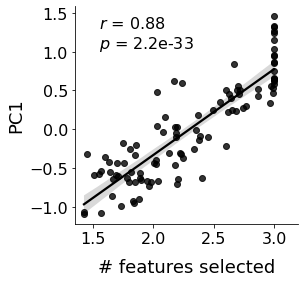

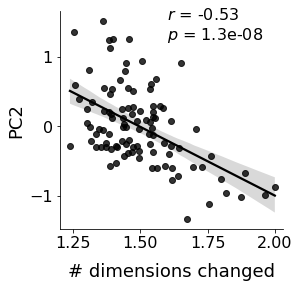

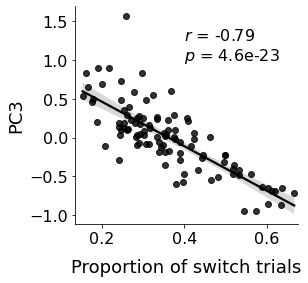

In [10]:
from scipy.stats import pearsonr

plt.rcParams.update({'font.size': 16})

for i, varName in enumerate(varNames):
    x = [metrics_real.loc[workerId, varName] for workerId in workerIds]
    y = principalComponents[:, i]
    fig, ax = plt.subplots(figsize=(4,4))
    r, p = pearsonr(x, y)
    sns.regplot(x=x, y=y, color='k', ax=ax)
    ax.text(x=text_loc[varName]['x'], y=text_loc[varName]['y'],s='$r$ = '+str(np.round(r,2))+'\n$p$ = '+'{:0.1e}'.format(p))
    ax.set_xlabel(varLabels[varName], fontsize=18, labelpad=12)
    ax.set_ylabel('PC' + str(i+1), fontsize=18)
    ax.set(xlim=xlims[varName])
    sns.despine()

## Comparison with simulation

### RNN model information

### Load simulated data and get metrics

In [11]:
metrics_simu = dict()
nets = ['LSTM', 'LSTM_embed', 'LSTM_embed_nTrialsRealData2']
for net in nets:
    simudata = pd.read_csv('model_simulation/' + net + '.csv')
    _, metrics = calculate_metrics(simudata, dataType='simu')
    metrics_simu[net] = metrics

### Histograms

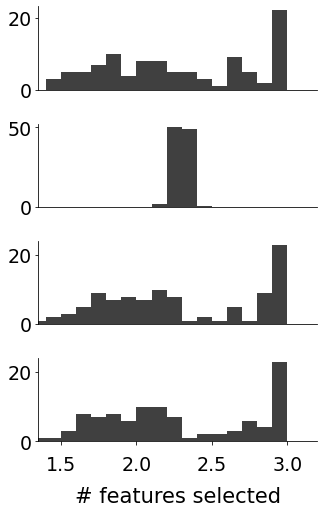

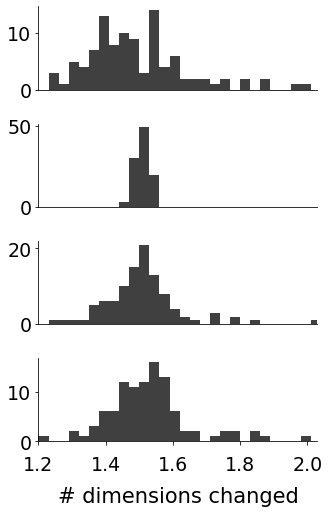

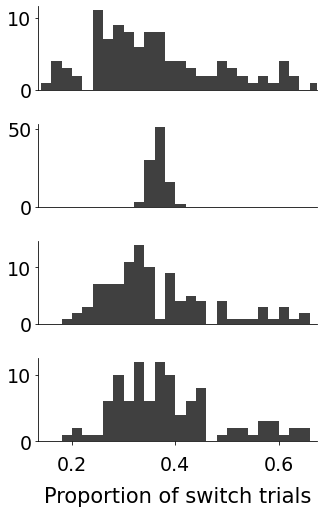

In [12]:
plt.rcParams.update({'font.size': 19})

for varName in varNames:
    fig, axes = plt.subplots(4,1,figsize=(5,4*2))
    for i in range(len(nets)+1):
        ax = axes[np.unravel_index(i,axes.shape)]
        if i == 0:
            metrics = metrics_real
        else:
            metrics = metrics_simu[nets[i-1]]
        ax.hist(metrics[varName],bins=bins[varName], color='k', alpha=0.75)
        ax.set_xlim(xlims[varName])
        if i < len(nets):
            ax.set_xticks([])
        else:
            ax.set_xticks(xticks[varName])
            ax.tick_params(axis='x', pad=10)
            ax.set_xlabel(varLabels[varName], labelpad=12, fontsize=21)
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        sns.despine()